In [5]:
import numpy as np
import pandas as pd
import pymc3 as pm, theano.tensor as tt
from pymc3.backends import Text
import matplotlib.pyplot as plt
import re

%matplotlib inline

## Pre-Processing

In [80]:
# Import season 2013/14 fixtures
df = pd.read_csv('./data/ts14-15.csv')
df = df.drop('Unnamed: 0', 1)

# Build team index
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index

df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)

df = df.sort_values(by='kick_off', ascending=1)

# Observed goals stats (Eyeball Poisson)
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values

home_team = df.i_home.values
away_team = df.i_away.values

num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)

# Add back to back fixture round index t
fixtures_per_round = num_teams/2
num_rounds = 38

rounds = np.array([[x]*(fixtures_per_round) for x in range(1,39)]).flatten()
df['t'] = 1
df['t'] = rounds

T = observed_home_goals.shape[0]

## Define model definition and sampling

In [10]:
# If run with T == 1, only fit timestep 1 without AR
def define_model(to_week):
    t = to_week
    
    with pm.Model() as model:    
        # global model parameters
        home = pm.Normal('home', mu=0, tau=0.0001)
        tau_att = pm.Gamma('tau_att', alpha=0.1, beta=0.1)
        tau_def = pm.Gamma('tau_def', alpha=0.1, beta=0.1)
        intercept = pm.Normal('intercept', mu=0, tau=0.0001)

        atts_star   = pm.Normal("atts_star",
                               mu = 0,
                               tau = tau_att,
                               shape = num_teams)
        defs_star   = pm.Normal("defs_star",
                               mu = 0,
                               tau = tau_def,
                               shape = num_teams)
        # Identifieability
        atts = pm.Deterministic('atts', atts_star - tt.mean(atts_star))
        defs = pm.Deterministic('defs', defs_star - tt.mean(defs_star))
        home_theta  = tt.exp(intercept + home + atts[home_team[:t*10]] + defs[away_team[:t*10]])
        away_theta  = tt.exp(intercept + atts[away_team[:t*10]] + defs[home_team[:t*10]])

        # Likelihood
        home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_goals[:t*10])
        away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_goals[:t*10])

    return model

In [ ]:
def sample(model, trace_len):
    # Sampling
    # If no previous model runs, find map as starting point
    # otherwise use estimates from previous model run
    # No starting point for atts_ni{t+1} and defs respectively, could use atts_ni{t} estimates instead
    if (t == 1):
        start = pm.find_MAP()
    else:
        tracename = "trace_exp_1_nuts_" + str(t-1)

        print "Load last trace '" + tracename + "'"

        trace_loaded = pm.backends.text.load(tracename)
        pattern = re.compile("(atts\d|defs\d|.*_ni" + str(t) + ")")
        start = {key: np.mean(trace_loaded[key], axis=0) for key in trace_loaded.varnames if pattern.match(key) == None}

    # step = pm.NUTS()
    step = pm.NUTS()
    db = Text("trace_exp_1_nuts_{0}".format(t))
    trace = pm.sample(trace_len, step, start=start, trace=db)

## Sample 38 games

In [3]:
# Already done

## Pickle all chains and the last model/trace for summary

In [12]:
models = []
traces = []

for i in range(1,38+1):
    print "Define model for week %d" %(i)
    m = define_model(i)
    models.append(m)
    
    with m:
        print "Load trace %s" %(tracename)
        tracename = "/Users/moe/Development/busics/thesis/notebooks/nuts/nuts_trace_exp_1_" + str(i)
        trace = pm.backends.text.load(tracename)
        traces.append(trace)

Define model for week 1
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
Define model for week 2
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
Define model for week 3
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
Define model for week 4
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
Define model for week 5
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied log-transform to tau_def and added transformed tau_def_log to model.
Define model for week 6
Applied log-transform to tau_att and added transformed tau_att_log to model.
Applied l

In [32]:
# Pickle all samples
samples = []

for t in traces:
    atts = np.swapaxes(t['atts'],0,1)
    defs = np.swapaxes(t['defs'],0,1)
    home = t['home']
    intercept = t['intercept']
    tau_att = t['tau_att']
    tau_def = t['tau_def']
    
    samples.append({'atts': atts, 'defs': defs, 'home': home,
                   'intercept': intercept, 'tau_att': tau_att, 'tau_def': tau_def})
    
import pickle
pickle.dump(samples, open("samples-static.p", "wb"))

In [39]:
# Pickle last model and trace
import pickle
pickle.dump(models[-1], open("static-model-38.p", "wb"))
pickle.dump(traces[-1], open("static-trace-38.p", "wb"))

# Analysis - Load pickles

In [3]:
import pickle
samples = pickle.load(open("samples-static.p", "rb"))
model38 = pickle.load(open("static-model-38.p", "rb"))
trace38 = pickle.load(open("static-trace-38.p", "rb"))

## Posterior summary from t=38

In [43]:
with model38:
    pm.summary(trace38, varnames=['intercept'])


intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.037            0.051            0.001            [-0.061, 0.137]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -0.063         0.004          0.037          0.071          0.135



## Posterior and Chain Plots for Top, Mid and Bottom team at t=1 and t=38

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/axes.py:4747: UserWarning: No labeled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labeled objects found. "


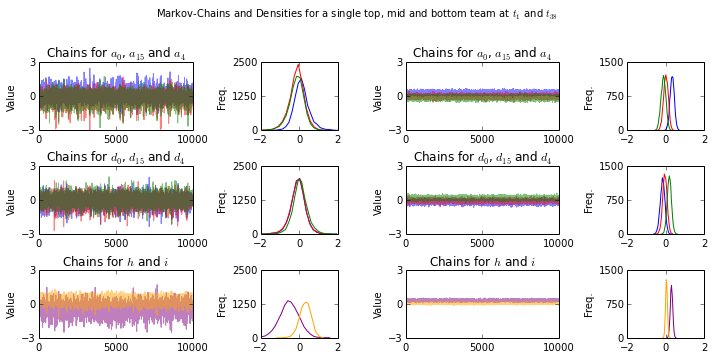

In [38]:
tr_atts38 = samples[37]['atts'][[0,15,4],:]
tr_defs38 = samples[37]['defs'][[0,15,4],:]

tr_global38 = []
tr_global38.append(samples[37]['home'])
tr_global38.append(samples[37]['intercept'])

tr_atts1 = samples[0]['atts'][[0,15,4],:]
tr_defs1 = samples[0]['defs'][[0,15,4],:]

tr_global1 = []
tr_global1.append(samples[0]['home'])
tr_global1.append(samples[0]['intercept'])

xs = range(0,10000)

import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(3, 4, width_ratios=[3,1.5,3,1.5], height_ratios=[1,1,1,1])

fig = plt.figure(figsize=(10, 6))

cols = 4
rows = 3

ax = [[plt.subplot(gs[i,j]) for j in range(cols)] for i in range(rows)]

for i in range(0,3):
    for j in range(cols):
        # Set titles
        if (i == 0):
            ax[i][0].set_title(r'Chains for $a_{0}$, $a_{15}$ and $a_{4}$')
            ax[i][2].set_title(r'Chains for $a_{0}$, $a_{15}$ and $a_{4}$')
        if (i == 1):
            ax[i][0].set_title(r'Chains for $d_{0}$, $d_{15}$ and $d_{4}$')
            ax[i][2].set_title(r'Chains for $d_{0}$, $d_{15}$ and $d_{4}$')
        if (i == 2):
            ax[i][0].set_title(r'Chains for $h$ and $i$')
            ax[i][2].set_title(r'Chains for $h$ and $i$')
            
        # Set ranges and axis
        if (j == 0):
            ax[i][j].set_ylabel('Value')
            ax[i][j].axis([0, 10000, -3, 3])
            ax[i][j].set_xticks(np.arange(0, 10001, 5000))
            ax[i][j].set_yticks(np.arange(-3, 3.1, 3))
        if (j == 1):
            ax[i][j].set_ylabel('Freq.')
            ax[i][j].axis([-2, 2, 0, 2500])
            ax[i][j].set_xticks(np.arange(-2, 2.1, 2))
            ax[i][j].set_yticks(np.arange(0, 2501, 1250))
        if (j == 2):
            ax[i][j].set_ylabel('Value')
            ax[i][j].axis([0, 10000, -3, 3])
            ax[i][j].set_xticks(np.arange(0, 10001, 5000))
            ax[i][j].set_yticks(np.arange(-3, 3.1, 3))
        if (j == 3):
            ax[i][j].set_ylabel('Freq.')
            ax[i][j].axis([-2, 2, 0, 1500])
            ax[i][j].set_xticks(np.arange(-2, 2.1, 2))
            ax[i][j].set_yticks(np.arange(0, 1501, 750))

colors = ['blue', 'red', 'green']
# Atts
for c in range(0,3):
    ax[0][0].plot(xs, tr_atts1[c], color=colors[c], alpha=0.5, label='Team')
    ax[0][2].plot(xs, tr_atts38[c], color=colors[c], alpha=0.5, label='Team')

    y, binEdges = np.histogram(tr_atts1[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[0][1].plot(bincenters, y, '-', color=colors[c])
    
    y, binEdges = np.histogram(tr_atts38[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[0][3].plot(bincenters, y, '-', color=colors[c])

# Defs
for c in range(0,3):
    ax[1][0].plot(xs, tr_defs1[c], color=colors[c], alpha=0.5, label='Team')
    ax[1][2].plot(xs, tr_defs38[c], color=colors[c], alpha=0.5, label='Team')

    y, binEdges = np.histogram(tr_defs1[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[1][1].plot(bincenters, y, '-', color=colors[c])
    
    y, binEdges = np.histogram(tr_defs38[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[1][3].plot(bincenters, y, '-', color=colors[c])
    
# Global
colors = ['purple', 'orange']
for c in range(0,2):
    ax[2][0].plot(xs, tr_global1[c], color=colors[c], alpha=0.5, label='Team')
    ax[2][2].plot(xs, tr_global38[c], color=colors[c], alpha=0.5, label='Team')    

    y, binEdges = np.histogram(tr_global1[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[2][1].plot(bincenters, y, '-', color=colors[c])
    
    y, binEdges = np.histogram(tr_global38[c],bins=25)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    ax[2][3].plot(bincenters, y, '-', color=colors[c]) 

plt.tight_layout()
plt.subplots_adjust(top=0.8)
plt.legend()
plt.suptitle('Markov-Chains and Densities for a single top, mid and bottom team at $t_1$ and $t_{38}$')
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/posterior-and-chains-static.pdf",bbox_inches='tight')
plt.show()

## Analyse Autocorrelation

(array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
          3,   4,   5,   6,   7,   8,   9,  10]),
 array([ 0.84768011,  0.84712594,  0.84740498,  0.84977718,  0.84803292,
         0.85032516,  0.85151866,  0.85304214,  0.85932263,  0.86127785,
         1.        ,  0.86127785,  0.85932263,  0.85304214,  0.85151866,
         0.85032516,  0.84803292,  0.84977718,  0.84740498,  0.84712594,
         0.84768011]),
 <matplotlib.lines.Line2D at 0x15c675210>)

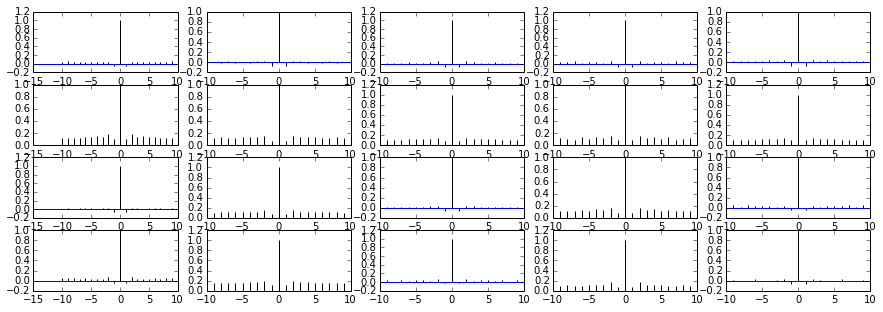

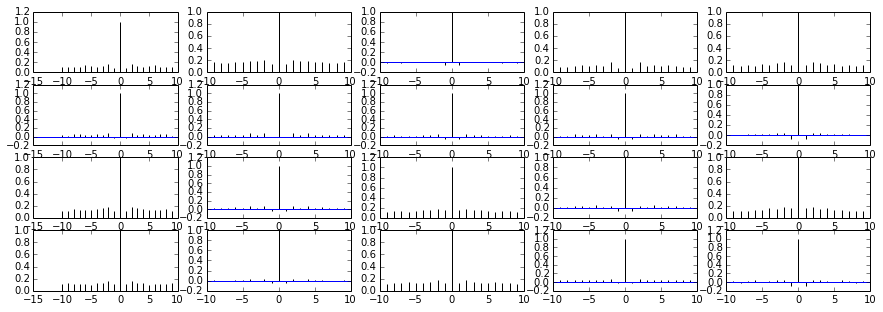

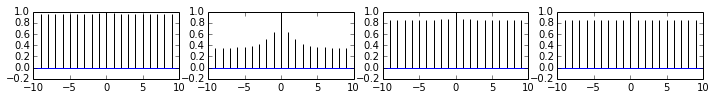

In [44]:
from pandas.tools.plotting import autocorrelation_plot

fig_att, ax_def = plt.subplots(4,5,figsize=(15,5))
fig_def, ax_att = plt.subplots(4,5,figsize=(15,5))

c = 0
for i in range(0,4):
    for j in range(0,5):
        ax_att[i,j].acorr(samples[0]['atts'][c])
        ax_def[i,j].acorr(samples[0]['defs'][c])
        c += 1
        
fig_misc, ax_misc = plt.subplots(1,4,figsize=(12,1.2))

ax_misc[0].acorr(home)
ax_misc[1].acorr(intercept)
ax_misc[2].acorr(tau_att)
ax_misc[3].acorr(tau_def)

## Effective Sample Size and other

In [ ]:
## Calc stats

## Out-of-Sample Likelihood: 1-Step ahead prediction

In [77]:
from scipy.stats import poisson

num_weeks = 38
num_games = num_weeks * 10
ll = 0
ll_hg = 0
ll_ag = 0
act_home_points = []
act_away_points = []
sim_home_points_stat = []
sim_away_points_stat = []
sim_home_scored = []
sim_away_scored = []
act_home_scored = []
act_away_scored = []

for w in range(0, num_weeks):
    # Get fixtures and trace for week w
    a = away_team[w*10:w*10+10]
    h = home_team[w*10:w*10+10]
    t = samples[w]
    act_home = observed_home_goals[w*10:w*10+10]
    act_away = observed_away_goals[w*10:w*10+10]
    
    # Get samples for all 10 fixtures (20 teams) of week w
    home = t['home']
    intercept = t['intercept']
    atts = t['atts']
    defs = t['defs']

    # 10k compositions of home and away scoring intensity parameter -> distribution
    lbda_home = np.exp(home + atts[h] + defs[a] + intercept)
    lbda_away = np.exp(atts[a] + defs[h] + intercept)
    sim_home = poisson.rvs(lbda_home)
    sim_away = poisson.rvs(lbda_away)
    act_gd = act_home - act_away
    
    # Prediction: Counting realisations equaling actual outcome
    sim_home = np.swapaxes(sim_home,0,1)
    sim_away = np.swapaxes(sim_away,0,1)
    
    sim_home_scored.append(np.median(sim_home, axis=0))
    sim_away_scored.append(np.median(sim_away, axis=0))

    act_home_scored.append(act_home)
    act_away_scored.append(act_away)
    
    sim_gd = sim_home - sim_away
    
    # Calculate points with Median simulated outcomes
    sim_gd_md = np.median(sim_gd, axis=0)

    for gd in act_gd:
        if (gd > 0):
            act_home_points.append(3)
            act_away_points.append(0)
        elif (gd == 0):
            act_home_points.append(1)
            act_away_points.append(1)
        else:
            act_home_points.append(0)
            act_away_points.append(3)

    for gd in sim_gd_md:
        if (gd > 0):
            sim_home_points_stat.append(3)
            sim_away_points_stat.append(0)
        elif (gd == 0):
            sim_home_points_stat.append(1)
            sim_away_points_stat.append(1)
        else:
            sim_home_points_stat.append(0)
            sim_away_points_stat.append(3)
    
    l = sum(sim_gd == act_gd)/float(10000)
    l_hg = sum(sim_home == act_home)/float(10000)
    l_ag = sum(sim_away == act_away)/float(10000)
    
    ll += sum(np.log(l))
    ll_hg += sum(np.log(l_hg))
    ll_ag += sum(np.log(l_ag))
    
avg_ll = ll/num_games
avg_ll_hg = ll_hg/num_games
avg_ll_ag = ll_ag/num_games

print "Average Model Likelihood GD: %f" %(np.exp(avg_ll))
print "Average Model Likelihood Homegoals: %f" %(np.exp(avg_ll_hg))
print "Average Model Likelihood Awaygoals: %f" %(np.exp(avg_ll_ag))

Average Model Likelihood GD: 0.166816
Average Model Likelihood Homegoals: 0.236144
Average Model Likelihood Awaygoals: 0.276951


In [78]:
sim_home_scored = np.array(sim_home_scored)
sim_away_scored = np.array(sim_away_scored)
act_home_scored = np.array(act_home_scored)
act_away_scored = np.array(act_away_scored)

pickle.dump(sim_home_scored, open("sim-home-scored-stat.p", "wb"))
pickle.dump(sim_away_scored, open("sim-away-scored-stat.p", "wb"))
pickle.dump(act_home_scored, open("act-home-scored.p", "wb"))
pickle.dump(act_away_scored, open("act-away-scored.p", "wb"))

In [75]:
act_home_scored

array([ 1. ,  1. ,  1. ,  2. ,  1.5,  2. ,  2. ,  2. ,  1. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1.5,  1. ,  2. ,  1. ,  1. ,  2. ,  1. ,  0. ,
        1.5,  1. ,  1.5,  1.5,  1. ,  1. ,  1. ,  1.5,  2. ,  1. ,  1. ,
        1. ,  1. ,  1. ,  1.5,  2. ])

## Explanatory Analysis: Map Team Strength Parameters (End of Season)

In [56]:
## Table
# Calculate 95% CI
def stregnth_stats(samples):
    lb = np.percentile(samples, 2.5, axis=1)
    mn = np.mean(samples, axis=1)
    md = np.percentile(samples, 50, axis=1)
    ub = np.percentile(samples, 97.5, axis=1)
    return md, mn, lb, ub

def global_stats(samples):
    lb = np.percentile(samples, 2.5)
    mn = np.mean(samples)
    md = np.percentile(samples, 50)
    ub = np.percentile(samples, 97.5)
    return md, mn, lb, ub

att_md, att_mn, att_lb, att_ub = stregnth_stats(samples[37]['atts'])
def_md, def_mn, def_lb, def_ub = stregnth_stats(samples[37]['defs'])
home_md, home_mn, home_lb, home_ub = global_stats(samples[37]['home'])
intercept_md, intercept_mn, intercept_lb, intercept_ub = global_stats(samples[37]['intercept'])
tau_att_md, tau_att_mn, tau_att_lb, tau_att_ub = global_stats(samples[37]['tau_att'])
tau_def_md, tau_def_mn, tau_def_lb, tau_def_ub = global_stats(samples[37]['tau_def'])

effects_table = pd.DataFrame()

effects_table['team'] = teams['team']
effects_table['att_mn'] = np.round(att_mn,3)
effects_table['att_lb'] = np.round(att_lb,3)
effects_table['att_md'] = np.round(att_md,3)
effects_table['att_ub'] = np.round(att_ub,3)

effects_table['def_mn'] = np.round(def_mn,3)
effects_table['def_lb'] = np.round(def_lb,3)
effects_table['def_md'] = np.round(def_md,3)
effects_table['def_ub'] = np.round(def_ub,3)

effects_table

,team,att_mn,att_lb,att_md,att_ub,def_mn,def_lb,def_md,def_ub
0,Arsenal,0.335,0.109,0.336,0.554,-0.168,-0.422,-0.163,0.068
1,Chelsea,0.356,0.130,0.356,0.577,-0.232,-0.497,-0.229,0.007
2,Manchester United,0.215,-0.018,0.215,0.437,-0.158,-0.410,-0.154,0.078
3,Liverpool,0.071,-0.174,0.073,0.310,-0.002,-0.232,-0.001,0.223
4,Newcastle United,-0.123,-0.384,-0.119,0.124,0.186,-0.035,0.187,0.404
5,Aston Villa,-0.305,-0.599,-0.301,-0.034,0.107,-0.112,0.107,0.324
6,Southampton,0.096,-0.147,0.096,0.332,-0.229,-0.488,-0.225,0.008
7,Everton,0.009,-0.241,0.010,0.255,0.023,-0.198,0.025,0.242
8,Tottenham Hotspur,0.167,-0.068,0.170,0.394,0.070,-0.162,0.071,0.298
9,Manchester City,0.478,0.264,0.478,0.690,-0.132,-0.389,-0.128,0.107


In [61]:
global_table = pd.DataFrame()

global_table['home'] = np.round((home_mn, home_lb, home_md, home_ub),3)
global_table['intercept'] = np.round((intercept_mn, intercept_lb, intercept_md, intercept_ub),3)
global_table['ta'] = np.round((tau_att_mn, tau_att_lb, tau_att_md, tau_att_ub),3)
global_table['td'] = np.round((tau_def_mn, tau_def_lb, tau_def_md, tau_def_ub),3)

global_table.T

,0,1,2,3
home,0.300,0.171,0.300,0.427
intercept,0.037,-0.063,0.037,0.135
ta,13.064,5.278,12.251,25.540
td,25.409,10.115,23.531,51.688


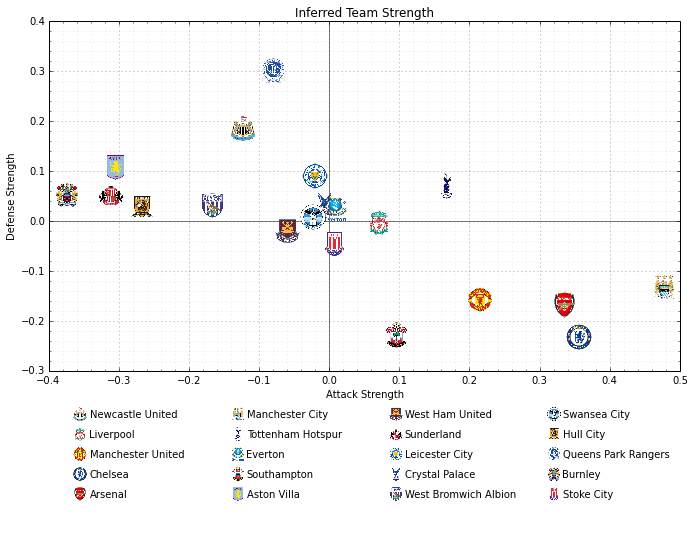

In [7]:
import matplotlib.gridspec as gridspec
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib._png import read_png

atts = samples[37]['atts']
mean_atts = [n.mean() for n in atts]

defs = samples[37]['defs']
mean_defs = [n.mean() for n in defs]

lv = pd.DataFrame(data=teams, columns=['team'])
lv['attack'] = mean_atts
lv['defense'] = mean_defs

gs = gridspec.GridSpec(2, 1, width_ratios=[1,1], height_ratios=[3.5,1])

fig = plt.figure(figsize=(18.5, 7.5))

ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :])

ax1.axis([-0.4, 0.5, -0.3, 0.4])

ax1.set_xticks(np.arange(-0.4, 0.55, 0.1))
ax1.set_xticks(np.arange(-0.4, 0.5, 0.02), minor=True)
ax1.set_yticks(np.arange(-0.3, 0.45, 0.1))
ax1.set_yticks(np.arange(-0.3, 0.4, 0.02), minor=True)

ax1.yaxis.grid(True, which='major', alpha=0.5)
ax1.yaxis.grid(True, which='minor', alpha=0.2)
ax1.xaxis.grid(True, which='major', alpha=0.5)
ax1.xaxis.grid(True, which='minor', alpha=0.2)

ax1.axhline(0, color='grey')
ax1.axvline(0, color='grey')

ax1.set_xlabel('Attack Strength')
ax1.set_ylabel('Defense Strength')
ax1.set_title("Inferred Team Strength")

for k,v in enumerate(lv.values):
    x = lv.iloc[k]['attack']
    y = lv.iloc[k]['defense']
    
    team = lv.iloc[k]['team'].lower().replace(" ", "_")
    
    ax1.scatter(x,y)
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.10)

    ab = AnnotationBbox(imagebox, (x,y), frameon=False)
    ax1.add_artist(ab)

ax2.axis('off')
ax2.axis([0, 1, 0.5, 1])

for k,v in enumerate(lv.values):
    if (k <= 4):
        x = 0
        y = k * 0.1
    elif (k <= 9):
        x = 0.25
        y = (k-5)*0.1
    elif (k <= 14):
        x = 0.5
        y = (k-10)*0.1
    else:
        x = 0.75
        y = (k-15)*0.1
    
    team = lv.iloc[k]['team'].lower().replace(" ", "_")
    team_name = lv.iloc[k]['team']
    
    file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
    icon = read_png(file)
    imagebox = OffsetImage(icon, zoom=0.055)

    crest = AnnotationBbox(imagebox, (x+0.05,y+0.015+0.58), frameon=False)
    ax2.add_artist(crest)
    ax2.annotate(team_name, xy=(x+0.015+0.05,y+0.58))

fig.tight_layout()

plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/team-parameters.pdf",bbox_inches='tight')
    
plt.show()

## Plot evolution of parameter estimates, when not modelled explicitely

In [17]:
# Calculate 95% CI
def mci(samples):
    lb = np.percentile(samples, 2.5, axis=1)
    mn = np.mean(samples, axis=1)
    md = np.percentile(samples, 50, axis=1)
    ub = np.percentile(samples, 97.5, axis=1)
    return md, mn, lb, ub

In [11]:
att_mcis = []
def_mcis = []

for i in range(0,38):
    t = samples[i]

    atts = t['atts']
    defs = t['defs']

    att_mcis.append(mci(atts))
    def_mcis.append(mci(defs))
    
att_mcis = np.swapaxes(np.array(att_mcis),0,2)
def_mcis = np.swapaxes(np.array(def_mcis),0,2)

xs = range(1,38+1)

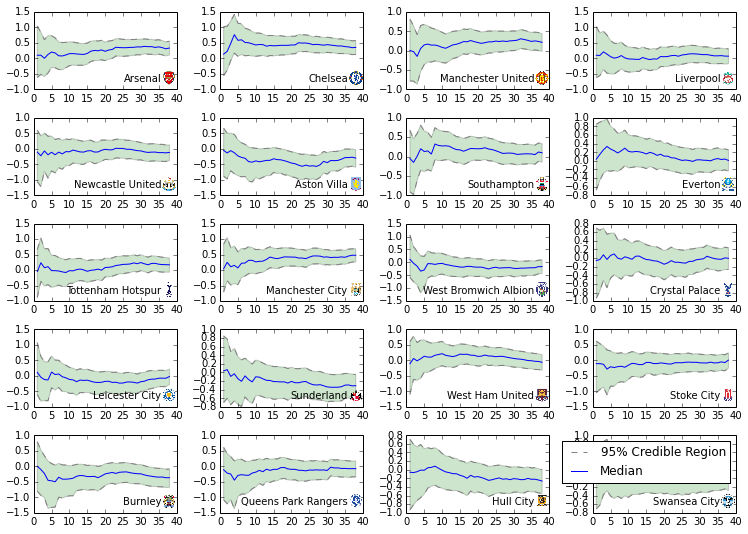

In [12]:
fig, ax = plt.subplots(5,4,figsize=(10.5,7.5))
c = 0
for i in range(0,5):
    for j in range(0,4):
        md = att_mcis[c][0]
        mn = att_mcis[c][1]
        lb = att_mcis[c][2]
        ub = att_mcis[c][3]

        ax[i][j].plot(xs, lb, '--', color='0.5', label='95% Credible Region')
        ax[i][j].plot(xs, md, marker=None, markersize=10, label='Median')
        ax[i][j].plot(xs, ub, '--', color='0.5')
        ax[i][j].fill_between(xs, lb, ub, facecolor='green', alpha=0.2)
        
        team = lv.iloc[c]['team'].lower().replace(" ", "_")
        team_name = lv.iloc[c]['team']

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.05,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.110,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        c += 1

fig.tight_layout()
plt.legend()
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-static-atts.pdf",bbox_inches='tight')
plt.show()

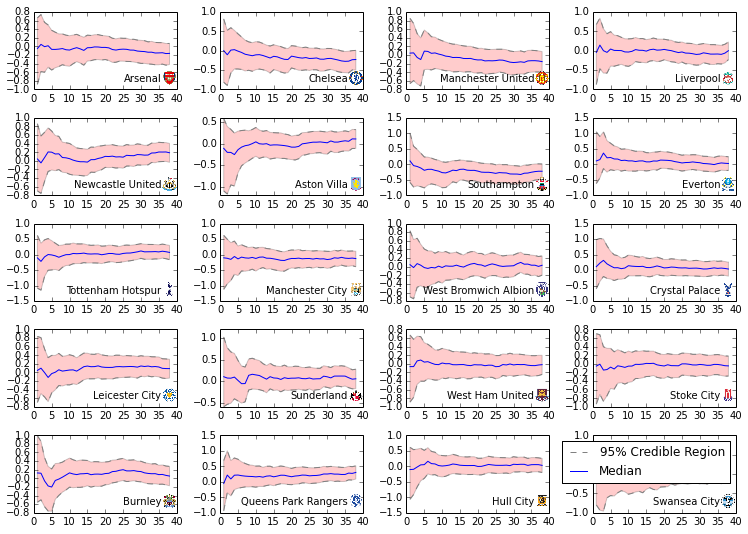

In [13]:
fig, ax = plt.subplots(5,4,figsize=(10.5,7.5))
c = 0
for i in range(0,5):
    for j in range(0,4):
        md = def_mcis[c][0]
        mn = def_mcis[c][1]
        lb = def_mcis[c][2]
        ub = def_mcis[c][3]

        ax[i][j].plot(xs, lb, '--', color='0.5', label='95% Credible Region')
        ax[i][j].plot(xs, md, marker=None, markersize=10, label='Median')
        ax[i][j].plot(xs, ub, '--', color='0.5')
        ax[i][j].fill_between(xs, lb, ub, facecolor='red', alpha=0.2)
        
        team = lv.iloc[c]['team'].lower().replace(" ", "_")
        team_name = lv.iloc[c]['team']

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.05,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.110,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        c += 1
#     ax[i].set_ylabel('Attack Strength')
#     ax[i].set_xlabel('Fixture Weeks of Season 2014/15')
#     ax[i].set_title("Team Strength Evolution")

fig.tight_layout()
plt.legend()
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-static-defs.pdf",bbox_inches='tight')
plt.show()

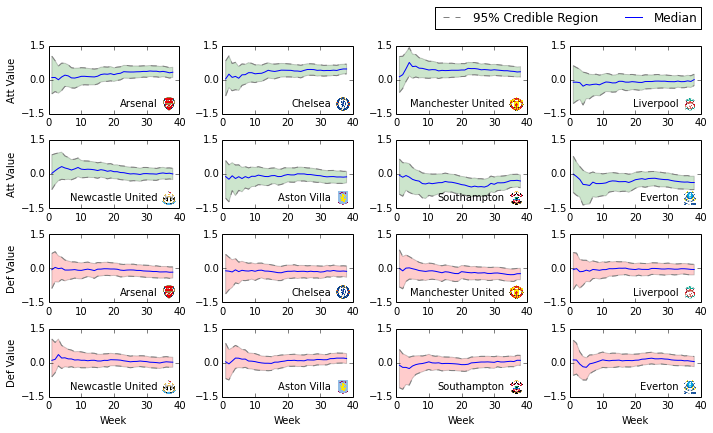

In [127]:
fig, ax = plt.subplots(4,4,figsize=(10,6))
c = 0
team_ix = [0,9,1,15,7,4,5,16]

for i in range(0,4):
    for j in range(0,4):
        cc = team_ix[c]
        
        att_md = att_mcis[cc][0]
        att_mn = att_mcis[cc][1]
        att_lb = att_mcis[cc][2]
        att_ub = att_mcis[cc][3]

        def_md = def_mcis[cc][0]
        def_mn = def_mcis[cc][1]
        def_lb = def_mcis[cc][2]
        def_ub = def_mcis[cc][3]
        
        if (i < 2):
            if (j == 0): ax[i][j].set_ylabel('Att Value')
            ax[i][j].axis([0, 40, -1.5, 1.5])
            ax[i][j].set_xticks(np.arange(0, 41, 10))
            ax[i][j].set_yticks(np.arange(-1.5, 1.51, 1.5))
            
            ax[i][j].plot(xs, att_lb, '--', color='0.5', label='95% Credible Region')
            ax[i][j].plot(xs, att_md, marker=None, markersize=10, label='Median')
            ax[i][j].plot(xs, att_ub, '--', color='0.5')
            ax[i][j].fill_between(xs, att_lb, att_ub, facecolor='green', alpha=0.2)
        else:
            if (j == 0): ax[i][j].set_ylabel('Def Value')
            if (i == 3): ax[i][j].set_xlabel('Week')
            ax[i][j].axis([0, 40, -1.5, 1.5])
            ax[i][j].set_xticks(np.arange(0, 41, 10))
            ax[i][j].set_yticks(np.arange(-1.5, 1.51, 1.5))
                                          
            ax[i][j].plot(xs, def_lb, '--', color='0.5', label='95% Credible Region')
            ax[i][j].plot(xs, def_md, marker=None, markersize=10, label='Median')
            ax[i][j].plot(xs, def_ub, '--', color='0.5')
            ax[i][j].fill_between(xs, def_lb, def_ub, facecolor='red', alpha=0.2)
        
        team = lv.iloc[c]['team'].lower().replace(" ", "_")
        team_name = lv.iloc[c]['team']

        file = get_sample_data("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/crests/" + team +  "_1.png", asfileobj=False)
        icon = read_png(file)
        imagebox = OffsetImage(icon, zoom=0.055)

        crest = AnnotationBbox(imagebox, xycoords='axes fraction', xy=(1-0.08,0.15), frameon=False)
        ax[i][j].add_artist(crest)
        ax[i][j].annotate(teams["team"][c], xycoords='axes fraction', xy=(1-0.175,0.075),
                         horizontalalignment='right', verticalalignment='bottom')
        
        if (c == 7): c = 0
        else: c += 1

fig.tight_layout()
ax[0][3].legend(loc='upper right', bbox_to_anchor=(1.05, 1.66), ncol=2)
plt.subplots_adjust(top=0.9)
# plt.suptitle('Median Out-of-Sample predicted Parameter Estimates')
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/evolution-uncertainty-static-atts-8.pdf",bbox_inches='tight')
plt.show()

## Correlation btw. latent parameters

In [15]:
t = samples[-1] # Use trace which is conditioned on all variables p(theta|x)
atts = t['atts']
defs = t['defs']
home = t['home']
intercept = t['intercept']
tau_att = t['tau_att']
tau_def = t['tau_def']

# Analyse correlation of model parameters for Arsenal

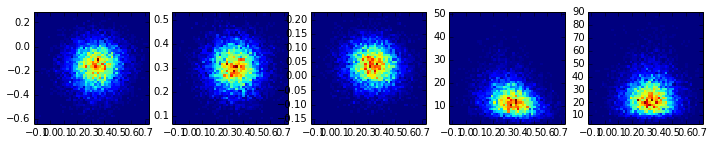

In [16]:
fig, ax = plt.subplots(1,5,figsize=(12,2))
ax[0].hist2d(atts[0], defs[0], bins=50)
ax[1].hist2d(atts[0], home, bins=50)
ax[2].hist2d(atts[0], intercept, bins=50)
ax[3].hist2d(atts[0], tau_att, bins=50)
ax[4].hist2d(atts[0], tau_def, bins=50)
plt.savefig("/Users/moe/Desktop/Drive/UCL/thesis/Oxford-Template/figures/2d-corrplot-static.pdf",bbox_inches='tight')
plt.show()